<h1 style="font-family: Trebuchet MS; font-size: 14px; color: #9e2a2b; text-align: right; ">Created By: Muhammad Faarisul Ilmi</h1>

<h1 style="font-family: Trebuchet MS; padding: 12px; font-size: 30px; color: #720026; text-align: center; line-height: 1.25;">Time Series Analysis<br><span style="color: #ff7f51; font-size: 48px"><b>💥Hourly Energy Consumption⚡️</b></span><br><span style="color: #ff7f51; font-size: 20px">💡Using 5 Different Models</span></h1>
<hr>

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #f7b538; text-align: center; "><b>If you find this notebook useful, give it a thumbs up 😉👍🏻</b></h1>

<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Table of Contents</p>

In this notebook, we will cover:
* [Overview](#0)
* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Data Transformation and EDA](#3)
* [Building Models](#4)
    1. [Prophet](#5)
    2. [XGBoost](#6)
    3. [Deep Neaural Network](#7)
* [Conclusion](#8)

<a id="0"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Overview</p>

![img](https://energyoptusa.com/wp-content/uploads/2019/10/bigstock-High-Voltage-Electric-Pole-And-299162803.jpg)

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia

This dataset contains over 10 years of hourly energy consumption data from PJM in Megawatts

This notebook will go through the model solution for univariate time series. There are endless models out there when it comes to time series, one of the most popular methods is Prophet developed by Facebook/Meta. So, we will take a look later at building models section. This time, not only that. we will use with 5 different approaches to see which one has the best performance

<a id="1"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Importing Libraries</p>

In [78]:
!pip install prophet

In [178]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

<a id="2"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Loading Dataset</p>

For this project, we are going to use just 3 of the dataset to get a sense of what it looks like as the approach for every one of them will be the same

In [80]:
df1 = pd.read_csv('../input/hourly-energy-consumption/AEP_hourly.csv', index_col='Datetime')
df2 = pd.read_csv('../input/hourly-energy-consumption/COMED_hourly.csv', index_col='Datetime')
df3 = pd.read_csv('../input/hourly-energy-consumption/DAYTON_hourly.csv', index_col='Datetime')
df4 = pd.read_csv('../input/hourly-energy-consumption/DEOK_hourly.csv', index_col='Datetime')
df5 = pd.read_csv('../input/hourly-energy-consumption/DOM_hourly.csv', index_col='Datetime')
df6 = pd.read_csv('../input/hourly-energy-consumption/DUQ_hourly.csv', index_col='Datetime')
df7 = pd.read_csv('../input/hourly-energy-consumption/EKPC_hourly.csv', index_col='Datetime')
df8 = pd.read_csv('../input/hourly-energy-consumption/FE_hourly.csv', index_col='Datetime')
df9 = pd.read_csv('../input/hourly-energy-consumption/NI_hourly.csv', index_col='Datetime')
df10 = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv', index_col='Datetime')
df11 = pd.read_csv('../input/hourly-energy-consumption/PJMW_hourly.csv', index_col='Datetime')

# For visualization purpose
df_final = df1.join([df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])

# We only use DAYTON_hourly.csv for modeling later since the approach is the same for each file
df = df3

In [81]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125361 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     125361 non-null  float64
 1   COMED_MW   70583 non-null   float64
 2   DAYTON_MW  125361 non-null  float64
 3   DEOK_MW    61825 non-null   float64
 4   DOM_MW     120275 non-null  float64
 5   DUQ_MW     123154 non-null  float64
 6   EKPC_MW    49421 non-null   float64
 7   FE_MW      66960 non-null   float64
 8   NI_MW      54778 non-null   float64
 9   PJME_MW    125361 non-null  float64
 10  PJMW_MW    125361 non-null  float64
dtypes: float64(11)
memory usage: 11.5+ MB


In [82]:
df_final.describe()

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW
count,125361.000000,70583.000000,125361.000000,61825.000000,120275.000000,123154.000000,49421.000000,66960.000000,54778.000000,125361.000000,125361.000000
mean,15363.077847,11237.756174,2017.668996,3041.597541,10845.028119,1642.043401,1435.357722,7663.627688,11713.761236,31759.038983,5531.513541
std,2661.589281,2357.022834,402.920846,637.299488,2438.253016,310.399093,382.815695,1386.468697,2363.414180,6643.720256,1008.678744
min,9581.000000,7237.000000,982.000000,907.000000,1253.000000,1014.000000,514.000000,0.000000,7003.000000,14544.000000,2553.000000
25%,13416.000000,9496.000000,1716.000000,2594.000000,9154.000000,1423.000000,1153.000000,6608.000000,9981.000000,27103.000000,4788.000000
50%,15206.000000,11018.000000,1994.000000,2971.000000,10402.000000,1618.000000,1365.000000,7606.000000,11530.000000,31182.000000,5447.000000
75%,17121.000000,12397.000000,2267.000000,3409.000000,12287.500000,1811.000000,1667.000000,8483.000000,12891.000000,35451.000000,6199.000000
max,25695.000000,23753.000000,3746.000000,5445.000000,21651.000000,3054.000000,3490.000000,14032.000000,23631.000000,62009.000000,9594.000000


<a id="3"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Data Transformation and EDA</p>

Text(0.5, 1.0, 'PJM Energy Cosumption')

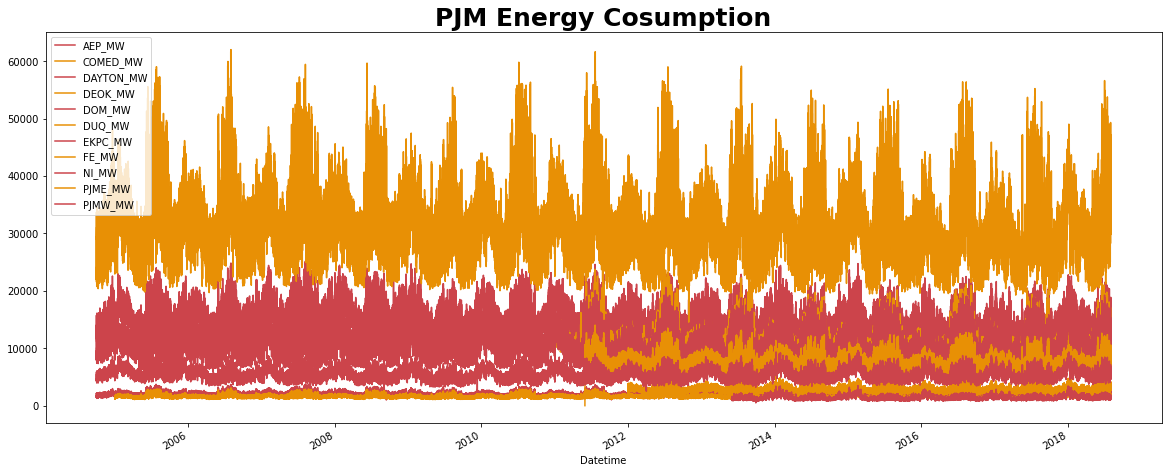

In [83]:
df_final.index = pd.to_datetime(df_final.index)

df_final.plot(figsize=(20,8))
plt.title('PJM Energy Cosumption', weight='bold', fontsize=25)

That's absolutely mess. However, we can see at the first glance that `PJME` has the highest energy consumption among the rest and all the column don't share the same datetime like `NI`, `EKPC`, and `DEOK`

Let's narrow it down to the first week of 2018 to see the graph more clearly

Text(0.5, 1.0, 'PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08')

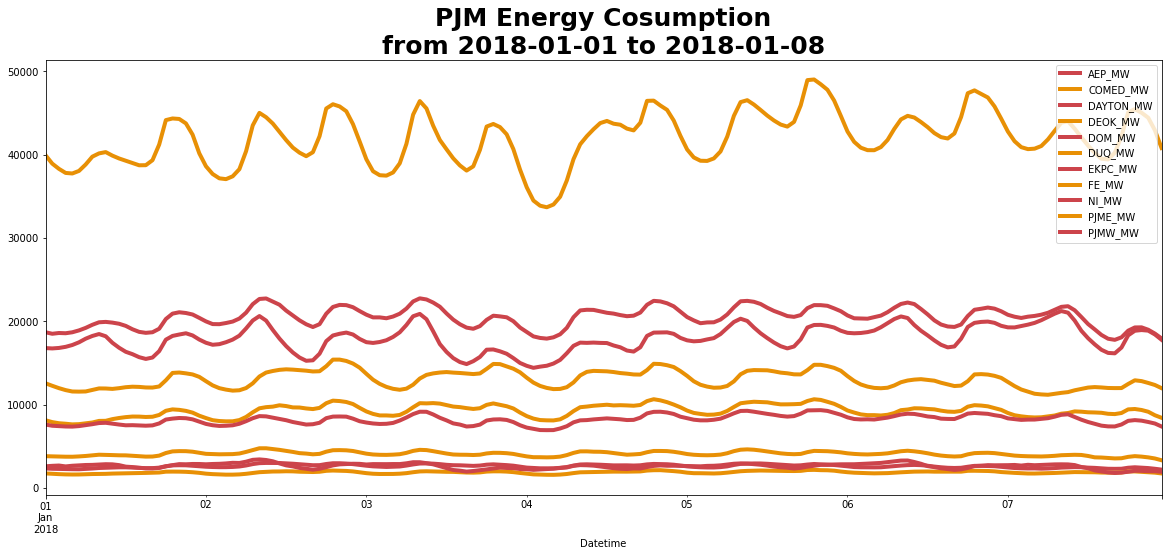

In [84]:
df_2018 = df_final[(df_final.index >= '2018-01-01') & (df_final.index < '2018-01-08')]

df_2018.plot(figsize=(20,8), lw=4)
plt.title('PJM Energy Cosumption\nfrom 2018-01-01 to 2018-01-08', weight='bold', fontsize=25)

In [85]:
df_final['Hour'] = df_final.index.hour
df_final['Day'] = df_final.index.day
df_final['Month'] = df_final.index.month
df_final['Quarter'] = df_final.index.quarter
df_final['Year'] = df_final.index.year

df_final.head(3)

,AEP_MW,COMED_MW,DAYTON_MW,DEOK_MW,DOM_MW,DUQ_MW,EKPC_MW,FE_MW,NI_MW,PJME_MW,PJMW_MW,Hour,Day,Month,Quarter,Year
Datetime,,,,,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,NaN,1621.0,NaN,NaN,NaN,NaN,NaN,9305.0,24025.0,4628.0,1,1,10,4,2004
2004-10-01 02:00:00,11935.0,NaN,1536.0,NaN,NaN,NaN,NaN,NaN,8681.0,22845.0,4520.0,2,1,10,4,2004
2004-10-01 03:00:00,11692.0,NaN,1500.0,NaN,NaN,NaN,NaN,NaN,8314.0,22138.0,4431.0,3,1,10,4,2004


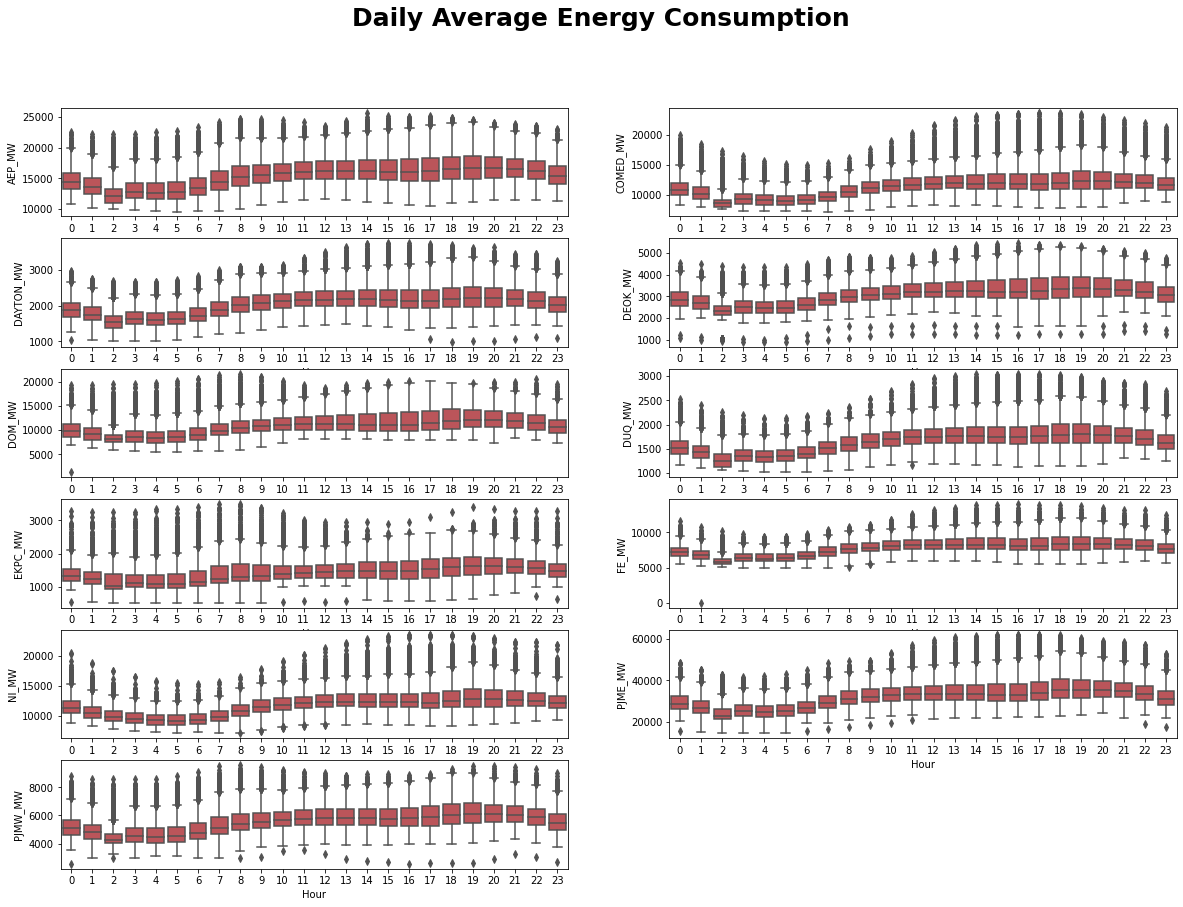

In [86]:
columns = ['AEP_MW', 'COMED_MW', 'DAYTON_MW', 'DEOK_MW', 'DOM_MW', 'DUQ_MW',
           'EKPC_MW', 'FE_MW', 'NI_MW', 'PJME_MW', 'PJMW_MW']

f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Daily Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.boxplot(data=df_final, x='Hour', y=col, ax=axes.flatten()[i], color='#cc444b')

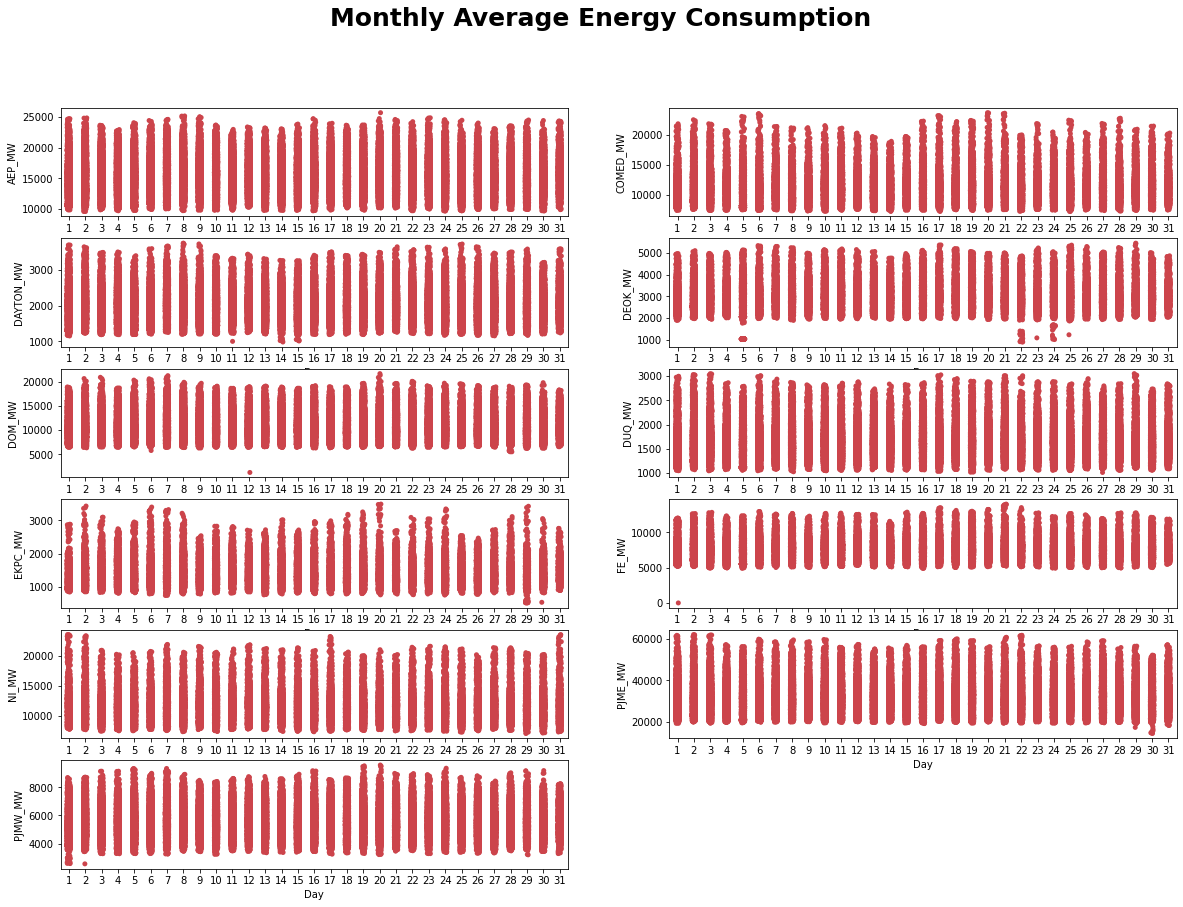

In [87]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Monthly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.stripplot(data=df_final, x='Day', y=col, ax=axes.flatten()[i], color='#cc444b')

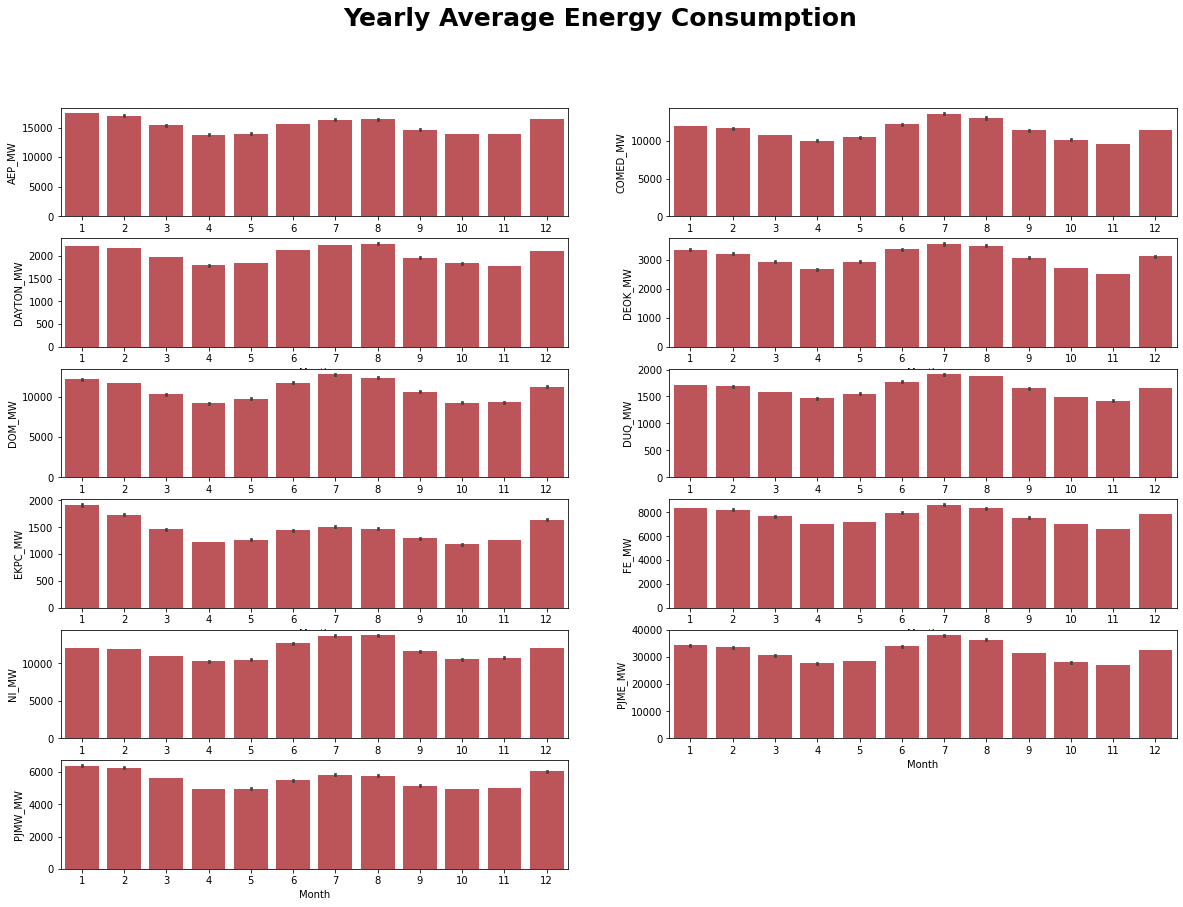

In [88]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Yearly Average Energy Consumption', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.barplot(data=df_final, x='Month', y=col, ax=axes.flatten()[i], color='#cc444b')

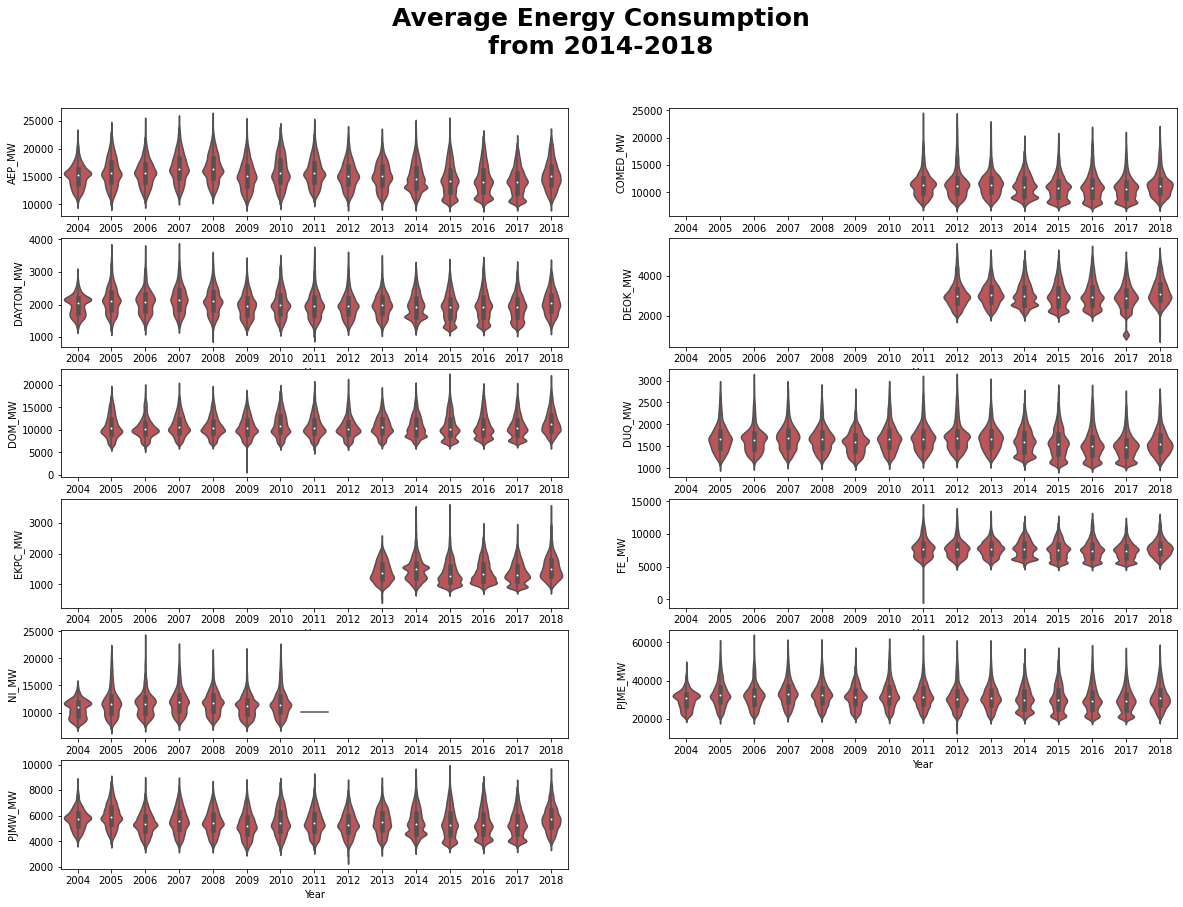

In [89]:
f, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 14))
f.suptitle('Average Energy Consumption\nfrom 2014-2018', weight='bold', fontsize=25)
# We just need 11 figures, so we delete the last one
f.delaxes(axes[5][1])

for i, col in enumerate(columns):
    sns.violinplot(data=df_final, x='Year', y=col, ax=axes.flatten()[i], color='#cc444b')

Our data have seasonality. That's why all visualization are pretty much the same for all the data or columns except for the year which some data have missing value in certain year

What are the insights we got from above EDA?
* `PJME` holds the highest energy consumption among others
* Daily peak/highest is around 6-8 PM and the trough/mininum is at 2 AM
* The highest energy consumption in a year is either in the end of the year or in the middle of the year
* Out of 11 data, 5 of them is not complete (2004-2018)

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>DATASET: DAYTON_MW</b></h1>

The actual column or data that we use in this notebook is from `DAYTON_MW` to simplify the process beccause the rest of the data will have the exact same approach as DAYTON

In [90]:
# Set color style
plt.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#cc444b', '#e89005'])

In [91]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# The data that we are going to use (DAYTON)
df.head()

,DAYTON_MW
Datetime,
2004-10-01 01:00:00,1621.0
2004-10-01 02:00:00,1536.0
2004-10-01 03:00:00,1500.0
2004-10-01 04:00:00,1434.0
2004-10-01 05:00:00,1489.0


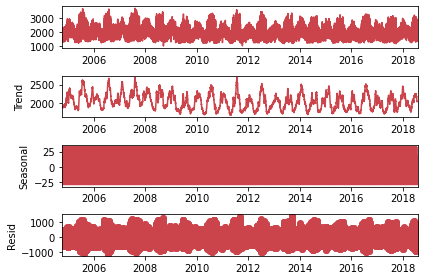

In [92]:
seasonal_decompose(df, period=365).plot()
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>Moving Average</b></h1>

In [93]:
# Daily Consumption
ma = df.resample('D').mean()

# 3 Day Example
ma['Moving Average'] = ma['DAYTON_MW'].rolling(3).mean()
ma.head()

,DAYTON_MW,Moving Average
Datetime,,
2004-10-01,1924.130435,NaN
2004-10-02,1641.583333,NaN
2004-10-03,1528.708333,1698.140700
2004-10-04,1926.541667,1698.944444
2004-10-05,1970.125000,1808.458333


In [94]:
def moving_average(data, window):
    data['Moving Average'] = data['DAYTON_MW'].rolling(window).mean()
    actual = data['DAYTON_MW'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]
    
    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Days Moving Average'.format(str(window)), weight='bold', fontsize=25)
    plt.legend()

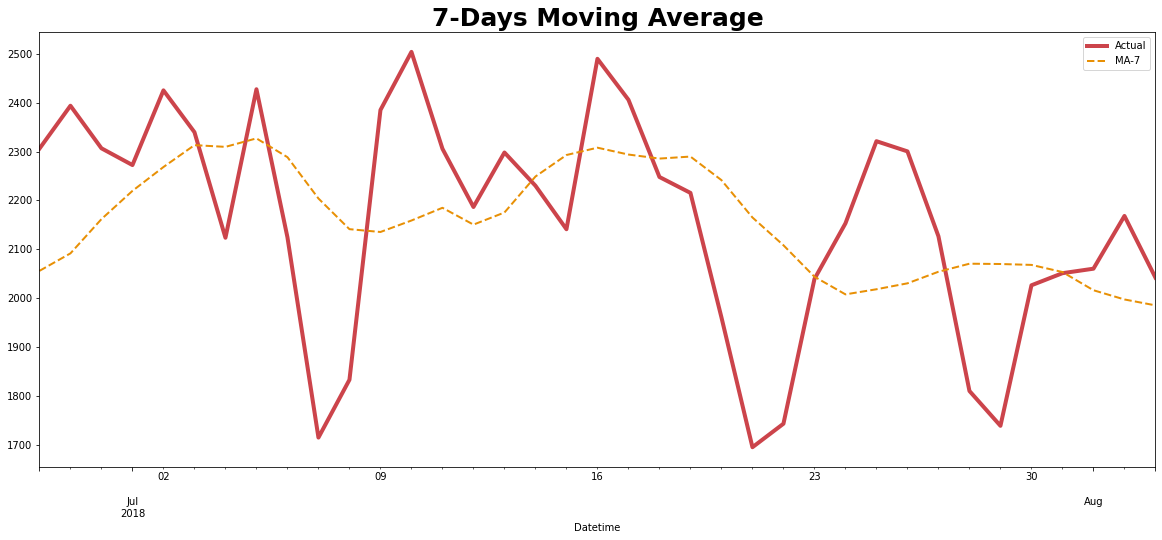

In [95]:
moving_average(ma, 7)

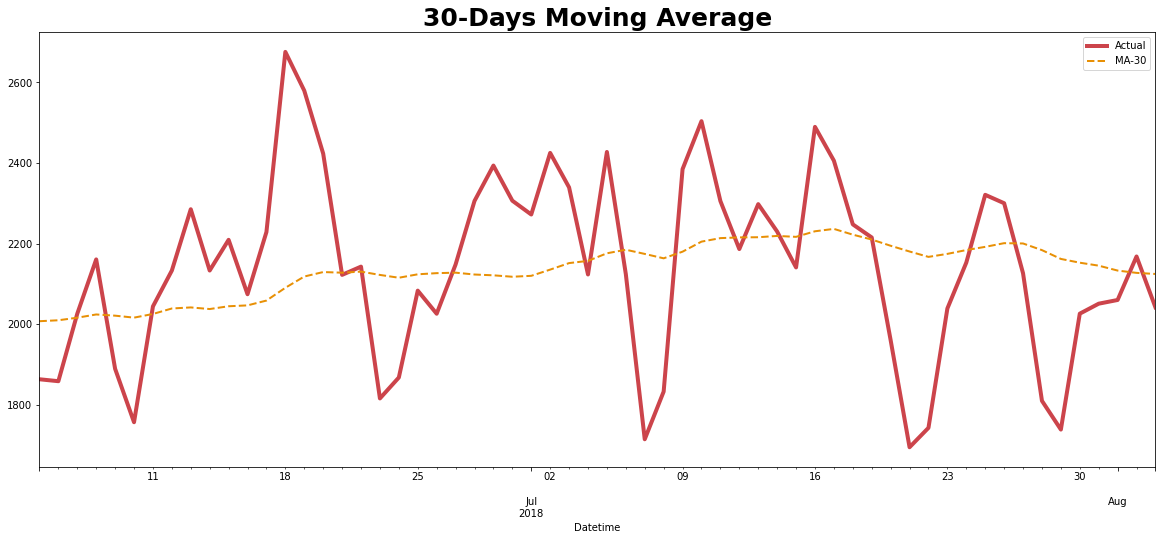

In [96]:
moving_average(ma, 30)

In [97]:
# Before building and training our model, let's split the data into training and testing
df_train, df_test = df[df.index < '2016-01-01'], df[df.index >= '2016-01-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 98595
Test:	 22680


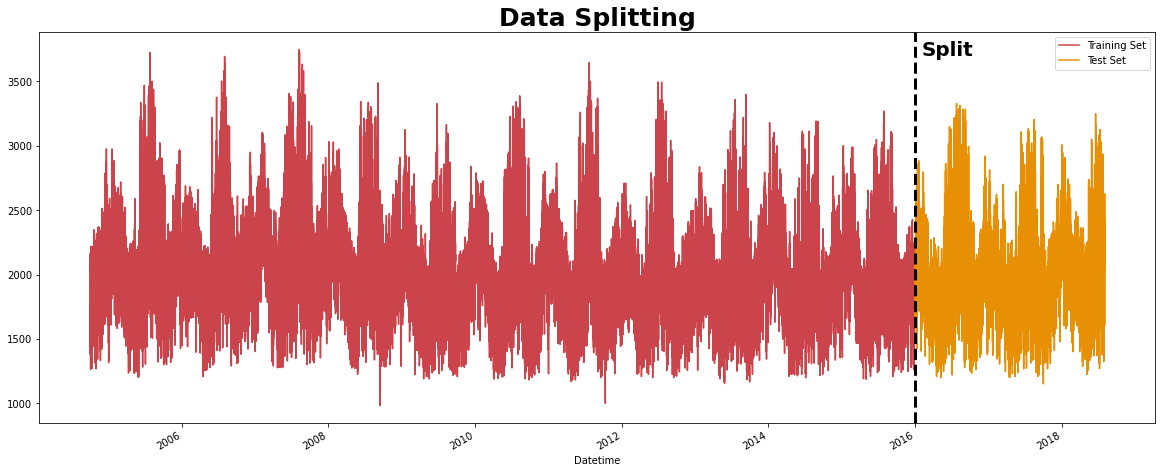

In [98]:
plt.figure(figsize=(20,8))

df_train['DAYTON_MW'].plot(label='Training Set')
df_test['DAYTON_MW'].plot(label='Test Set')
plt.axvline('2016-01-01', color='black', ls='--', lw=3)
plt.text('2016-02-01', 3700, 'Split', fontsize=20, fontweight='bold')
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend()

<a id="4"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Building Models</p>

<a id="5"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>1. Prophet</b></h1>

Prophet is an open-source library for univariate (one variable) time series forecasting developed by Facebook. It works best with time series that have strong seasonal effects and several seasons of historical data

Official Documentation: [Here](http://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)

Helpful Resources: 
* https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
* https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet/notebook

In [99]:
def index_to_column(data):
    data = data.reset_index()
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values('Datetime')
    
    data = data.rename(columns={'Datetime': 'ds', 'DAYTON_MW': 'y'})
    return data

In [100]:
prophet_train = index_to_column(df_train)
prophet_test = index_to_column(df_test)

In [101]:
prophet_model = Prophet(interval_width=0.95)

prophet_model.fit(prophet_train)
prophet_pred = prophet_model.predict(prophet_test[['ds']]) # Keep the dataset format

09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:49:53 - cmdstanpy - INFO - Chain [1] done processing


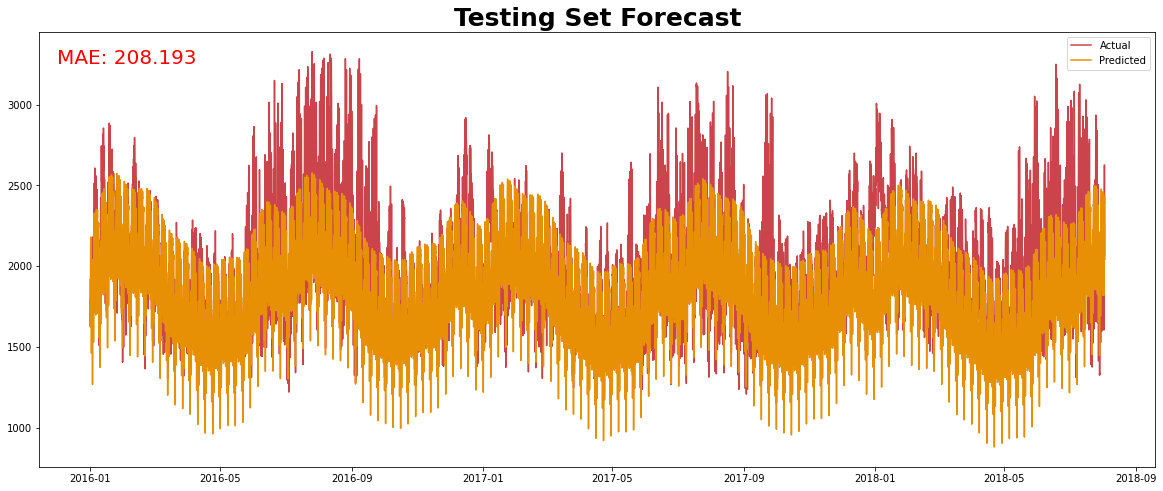

In [102]:
mae = round(mean_absolute_error(prophet_test['y'], prophet_pred['yhat']), 3)

plt.figure(figsize=(20,8))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Predicted')
plt.title('Test Forecasting', weight='bold', fontsize=40)
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Predict the value for next 7 days</b></h1>

In [103]:
# This time, we will use all data (train and test) to train our model
new_df = index_to_column(df)

In [104]:
prophet_model2 = Prophet(interval_width=0.95)
prophet_model2.fit(new_df)
# 7 days to the future (7x24 = 168)
future_dates = prophet_model2.make_future_dataframe(periods=168, freq='H')
prophet_pred2 = prophet_model2.predict(future_dates)

09:50:26 - cmdstanpy - INFO - Chain [1] start processing
09:54:02 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1440x576 with 0 Axes>

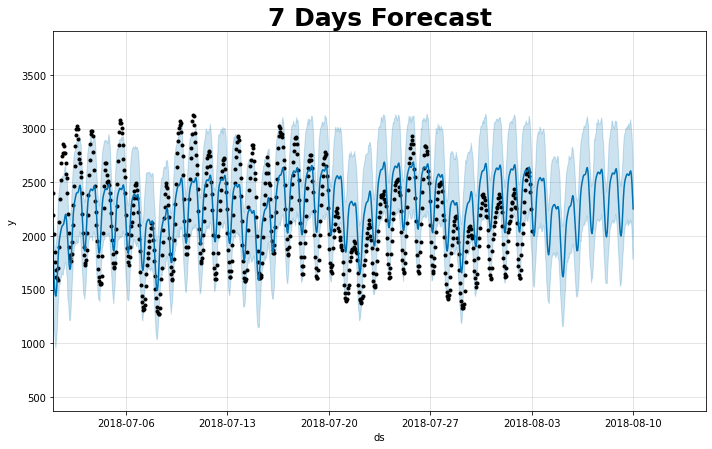

In [105]:
plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred2, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-08-15']))
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

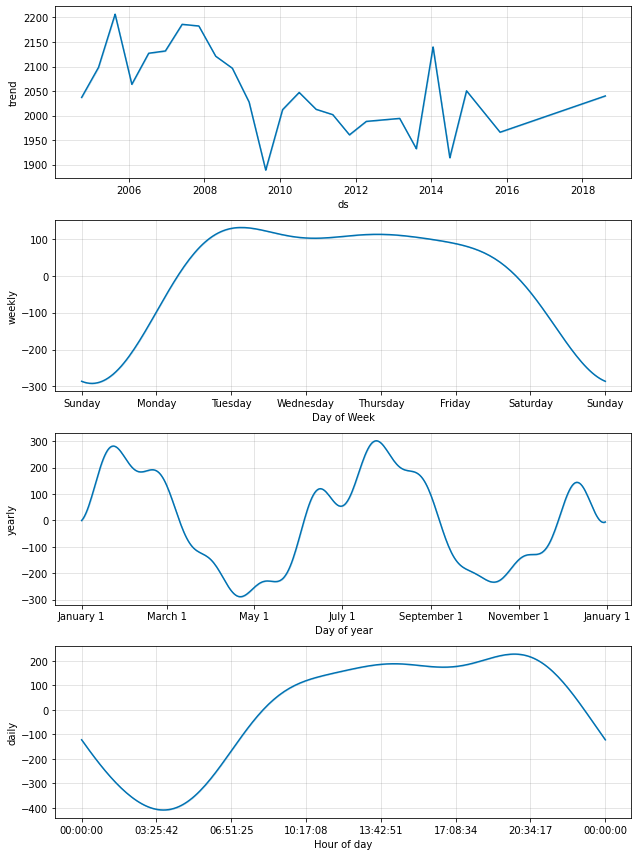

In [106]:
prophet_model.plot_components(prophet_pred2)
plt.show()

<Figure size 1440x576 with 0 Axes>

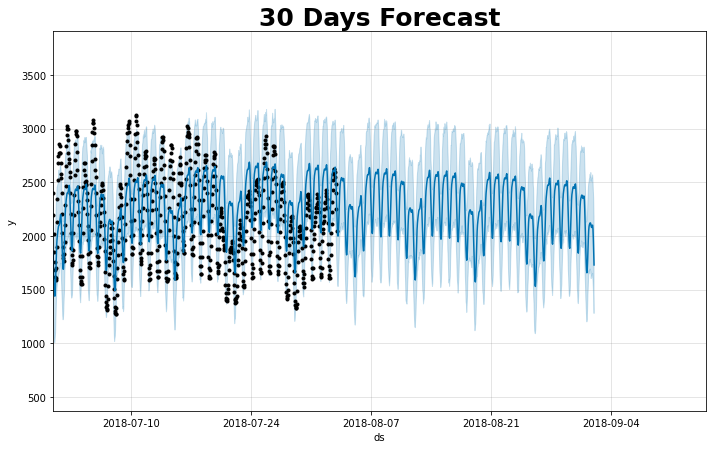

In [271]:
future_dates2 = prophet_model2.make_future_dataframe(periods=720, freq='H')
prophet_pred3 = prophet_model2.predict(future_dates2)

plt.figure(figsize=(20,8))

fig = prophet_model2.plot(prophet_pred3, uncertainty=True)
ax = fig.gca()
ax.set_xlim(pd.to_datetime(['2018-07-01', '2018-09-15']))
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

<a id="6"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>2. XGBoost</b></h1>

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm

The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems

To be able to use XGBoost for time series forecasting, the data should be transformed into supervised learning before feeding it into the model

Official Documentation: [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html)

Helpful Resources:
* https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
* https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

In [107]:
def date_transform(data):
    df = data.copy()
    
    df['Hour'] = df.index.hour
    df['Dayofweek'] = df.index.dayofweek
    df['Dayofmonth'] = df.index.day
    df['Dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    
    X = df.drop('DAYTON_MW', axis=1)
    y = df['DAYTON_MW']
    
    return X, y

In [108]:
X_train, y_train = date_transform(df_train)
X_test, y_test = date_transform(df_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [109]:
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
xgb_model.fit(X_train, y_train, eval_metric='mae', eval_set=[(X_train, y_train), (X_test, y_test)])
xgb_pred = xgb_model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-mae:1940.29813	validation_1-mae:1914.34630
[1]	validation_0-mae:1843.33246	validation_1-mae:1818.57857
[2]	validation_0-mae:1751.21403	validation_1-mae:1727.56571
[3]	validation_0-mae:1663.69971	validation_1-mae:1639.56677
[4]	validation_0-mae:1580.55842	validation_1-mae:1557.33410
[5]	validation_0-mae:1501.57253	validation_1-mae:1478.38449
[6]	validation_0-mae:1426.53517	validation_1-mae:1403.89960
[7]	validation_0-mae:1355.24711	validation_1-mae:1333.48977
[8]	validation_0-mae:1287.52372	validation_1-mae:1266.99870
[9]	validation_0-mae:1223.18415	validation_1-mae:1203.29710
[10]	validation_0-mae:1162.06097	validation_1-mae:1142.84372
[11]	validation_0-mae:1103.99054	validation_1-mae:1086.01553
[12]	validation_0-mae:1048.82219	validation_1-mae:1031.40206
[13]	validation_0-mae:996.41269	validation_1-mae:980.22963
[14]	validation_0-mae:946.62204	validation_1-mae:930.97670
[15]	validation_0-mae:899.32044	validation_1-mae:884.13578
[16]	validation_0-mae:854.38784	validati

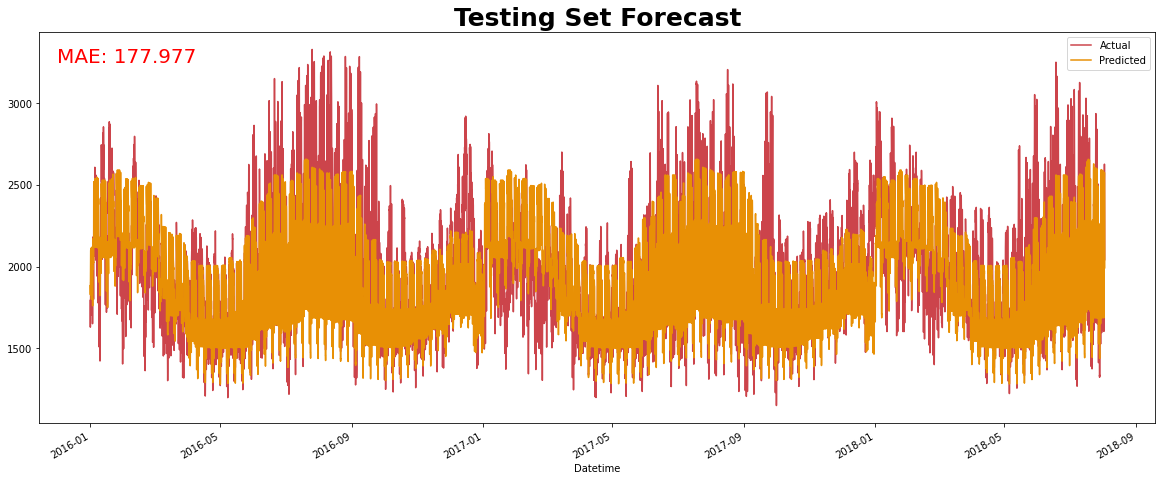

In [110]:
mae = round(mean_absolute_error(y_test, xgb_pred), 3)

df_plot = pd.DataFrame({'y_test':y_test, 'xgb_pred':xgb_pred})

plt.figure(figsize=(20,8))

df_plot['y_test'].plot(label='Actual')
df_plot['xgb_pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Predict the value for next 7 days</b></h1>

In [111]:
future_dates2 = future_dates.iloc[-168:, :].copy()

future_dates2['ds'] = pd.to_datetime(future_dates2['ds'])
future_dates2 = future_dates2.set_index('ds')

future_dates2['Hour'] = future_dates2.index.hour
future_dates2['Dayofweek'] = future_dates2.index.dayofweek
future_dates2['Dayofmonth'] = future_dates2.index.day
future_dates2['Dayofyear'] = future_dates2.index.dayofyear
future_dates2['weekofyear'] = future_dates2.index.weekofyear
future_dates2['Month'] = future_dates2.index.month
future_dates2['Quarter'] = future_dates2.index.quarter
future_dates2['Year'] = future_dates2.index.year

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # Remove the CWD from sys.path while we load stuff.


In [112]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [113]:
xgb_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model2.fit(X, y, eval_metric='mae')
xgb_pred2 = xgb_model2.predict(future_dates2)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


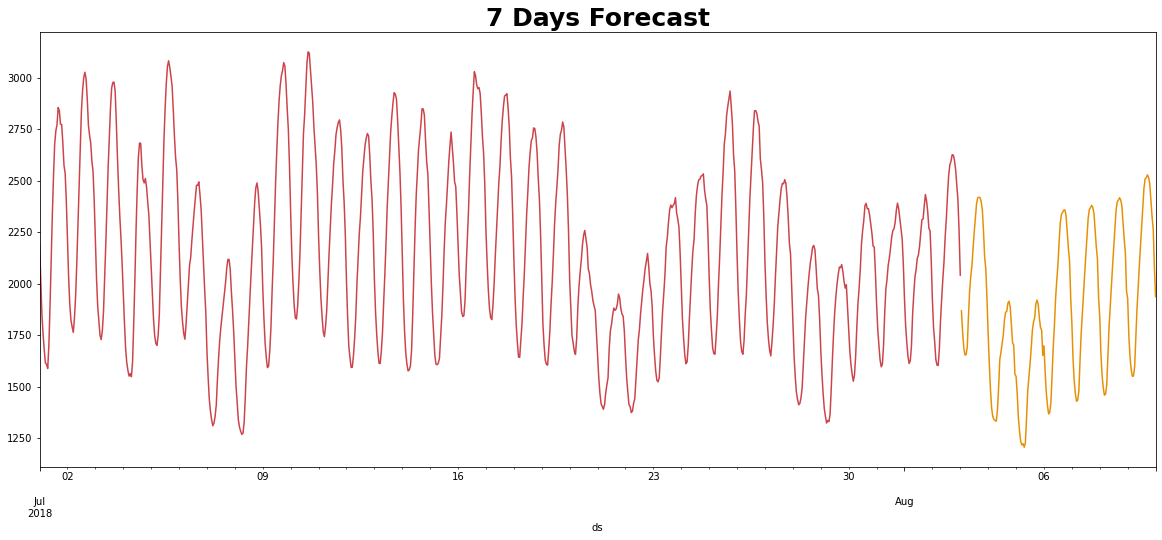

In [114]:
df_plot2 = pd.DataFrame({'Hour':future_dates2['Hour'], 'xgb_pred2':xgb_pred2})

last_week = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(20,8))

last_week['DAYTON_MW'].plot()
df_plot2['xgb_pred2'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


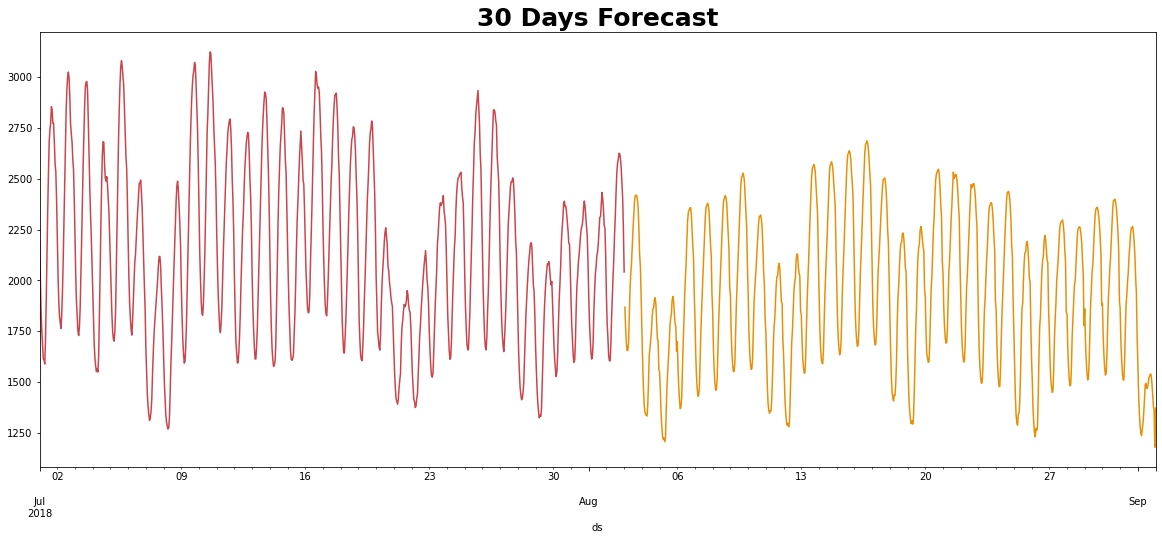

In [268]:
a = prophet_model2.make_future_dataframe(periods=720, freq='H')
future_dates3 = a.iloc[-720:, :].copy()

future_dates3['ds'] = pd.to_datetime(future_dates3['ds'])
future_dates3 = future_dates3.set_index('ds')

future_dates3['Hour'] = future_dates3.index.hour
future_dates3['Dayofweek'] = future_dates3.index.dayofweek
future_dates3['Dayofmonth'] = future_dates3.index.day
future_dates3['Dayofyear'] = future_dates3.index.dayofyear
future_dates3['weekofyear'] = future_dates3.index.weekofyear
future_dates3['Month'] = future_dates3.index.month
future_dates3['Quarter'] = future_dates3.index.quarter
future_dates3['Year'] = future_dates3.index.year

Xx = pd.concat([X_train, X_test], ignore_index=True)
yy = pd.concat([y_train, y_test], ignore_index=True)

xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(Xx, yy, eval_metric='mae')
xgb_pred3 = xgb_model3.predict(future_dates3)

df_plot3 = pd.DataFrame({'Hour':future_dates3['Hour'], 'xgb_pred2':xgb_pred3})

last_week3 = df['2018-07-01':'2018-08-15']

plt.figure(figsize=(20,8))

last_week3['DAYTON_MW'].plot()
df_plot3['xgb_pred2'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

<a id="7"></a>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #da627d; text-align: left; "><b>3. Deep Neural Network</b></h1>

The Deep Learning framework we are using is Tensorflow

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Preparing features and labels</b></h1>

Before feeding the data into Neural Network, we have to do some modification to the data so they can be accepted by the model. We are going to use windowing technique which basically group the data into feature and label. The label will be the next value. You can take a look at the next few cells to give an idea what we are going to do

Official Documentation: [Here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Helpful Resource:

* https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

In [115]:
# EXAMPLE

dataset = tf.expand_dims(df_train['DAYTON_MW'].head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[1621.]
 [1536.]
 [1500.]
 [1434.]]
y =  [1489.]

x =  [[1536.]
 [1500.]
 [1434.]
 [1489.]]
y =  [1620.]

x =  [[1500.]
 [1434.]
 [1489.]
 [1620.]]
y =  [1859.]

x =  [[1434.]
 [1489.]
 [1620.]
 [1859.]]
y =  [2007.]

x =  [[1489.]
 [1620.]
 [1859.]
 [2007.]]
y =  [2025.]

x =  [[1620.]
 [1859.]
 [2007.]
 [2025.]]
y =  [2067.]



<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Build and train the model</b></h1>

In [116]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [117]:
train = windowing(df_train['DAYTON_MW'], 24, 72, 32)
test = windowing(df_test['DAYTON_MW'], 24, 72, 32)

In [118]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 24, 16)            64        
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [119]:
dnn_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
3081/3081 [==============================] - 93s 29ms/step - loss: 186.6704 - val_loss: 134.9948
Epoch 2/20
3081/3081 [==============================] - 91s 29ms/step - loss: 135.2470 - val_loss: 165.2672
Epoch 3/20
3081/3081 [==============================] - 89s 29ms/step - loss: 167.1966 - val_loss: 164.5538
Epoch 4/20
3081/3081 [==============================] - 89s 29ms/step - loss: 166.9885 - val_loss: 163.9534
Epoch 5/20
3081/3081 [==============================] - 89s 29ms/step - loss: 167.0522 - val_loss: 165.1015
Epoch 6/20
3081/3081 [==============================] - 88s 29ms/step - loss: 166.7486 - val_loss: 166.8359
Epoch 7/20
3081/3081 [==============================] - 88s 29ms/step - loss: 166.6448 - val_loss: 166.3419
Epoch 8/20
3081/3081 [==============================] - 91s 29ms/step - loss: 166.3817 - val_loss: 165.2307
Epoch 9/20
3081/3081 [==============================] - 88s 29ms/step - loss: 152.3533 - val_loss: 95.8335
Epoch 10/20
3081/3081 [======

<AxesSubplot:>

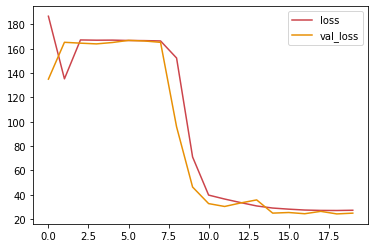

In [120]:
metric = pd.DataFrame(dnn_model.history.history)
metric.plot()

In [122]:
window_size = 24
forecast = []

train_length = len(df_train)
forecast_series = df[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


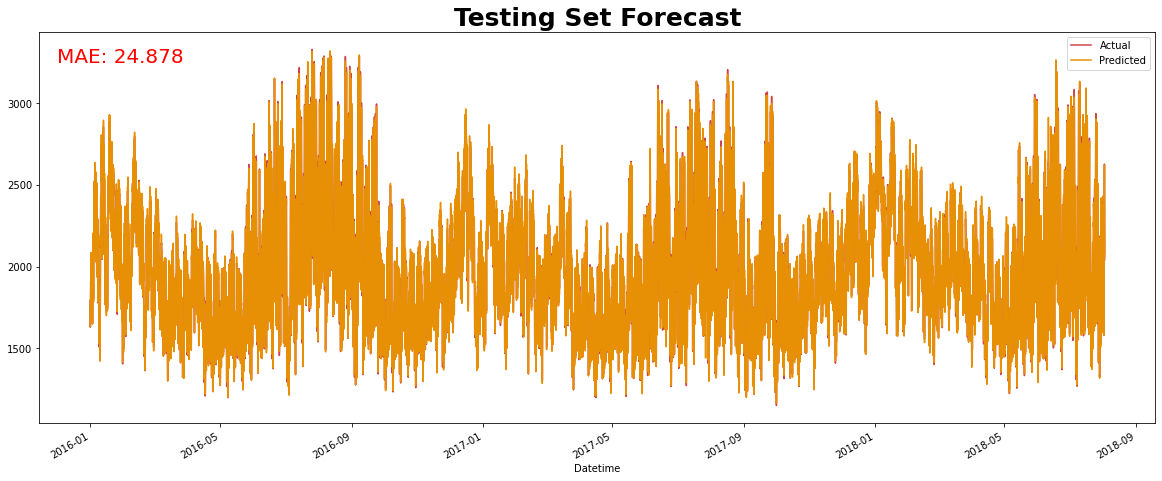

In [123]:
df_test['Pred'] = results

mae = round(mean_absolute_error(df_test['DAYTON_MW'], df_test['Pred']), 3)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'].plot(label='Actual')
df_test['Pred'].plot(label='Predicted')
plt.text(16770, 3250, 'MAE: {}'.format(mae), fontsize=20, color='red')
plt.title('Testing Set Forecast', weight='bold', fontsize=25)
plt.legend()
plt.show()

In [241]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(168): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    df_forecast = df_forecast.append({'Pred':pred}, ignore_index=True)
    
date_index = pd.date_range('2018-08-02 01:00:00', periods=192, freq='H') # 24+168
df_forecast.set_index(date_index, inplace=True)

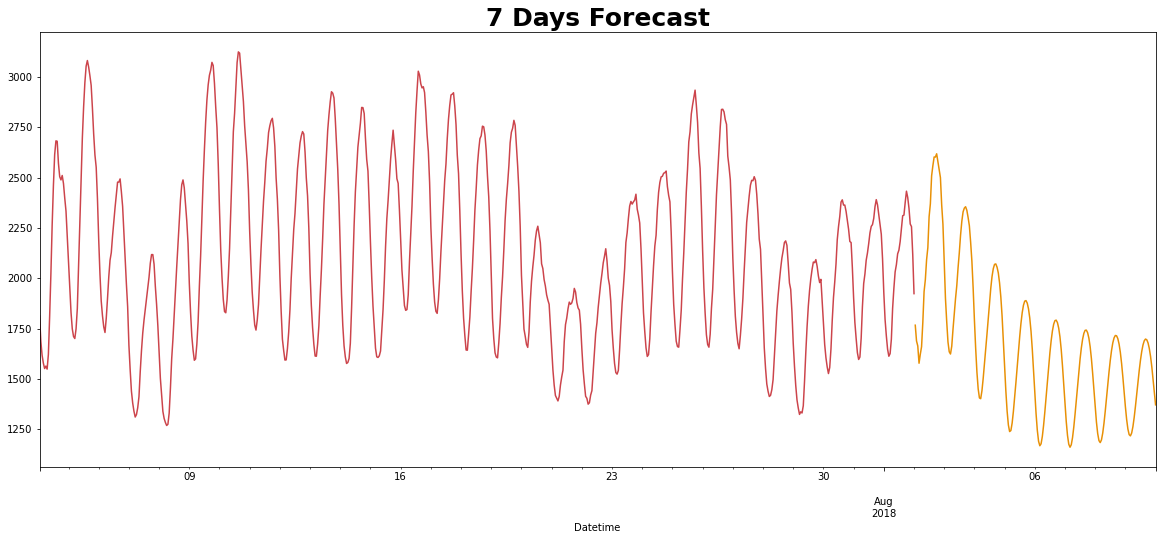

In [258]:
plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('7 Days Forecast', weight='bold', fontsize=25)
plt.show()

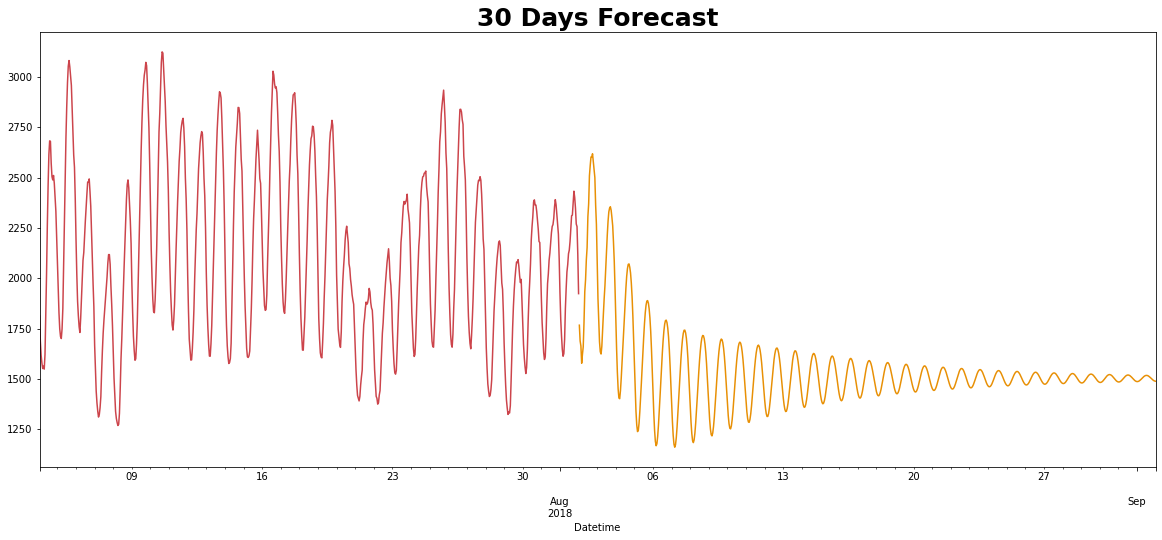

In [272]:
window_size = 24

df_forecast = df_test[['Pred']][-24:]
last_date = df_forecast.index

for time in range(720): # 7 days ahead
    pred = dnn_model.predict(np.expand_dims(df_forecast[time:time + window_size], axis=-1)[np.newaxis])[0][0]
    df_forecast = df_forecast.append({'Pred':pred}, ignore_index=True)
    
date_index = pd.date_range('2018-08-02 01:00:00', periods=744, freq='H') # 24+720
df_forecast.set_index(date_index, inplace=True)

plt.figure(figsize=(20,8))

df_test['DAYTON_MW'][-720:-24].plot()
df_forecast['Pred'].plot()
plt.title('30 Days Forecast', weight='bold', fontsize=25)
plt.show()

<a id="8"></a>
<p style="background-color:#720026;font-family:Trebuchet MS;font-weight:bold;color:#ff7f51;font-size:40px;text-align:center;border-radius:100px 100px">Conclusion</p>

With the series of forecasting we have done using 3 methods, we can draw a simple conclusion that DNN gives a better performance in the testing set. However, unlike the Prophet and XGBoost, it struggles to forecast far ahead as the predicted values become convergence 

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #f7b538; text-align: center; "><b>If you find this notebook useful, give it a thumbs up 😉👍🏻</b></h1>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #fb8500; text-align: center; "><b>If there is mistakes or you have any feedbacks or suggestions on how to improve model performance, please let me know in the comment</b></h1>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #fb8500; text-align: center; "><b>THANK YOU</b></h1>

<h1 style="font-family: Trebuchet MS; font-size: 60px; color: #9e2a2b; text-align: center;"><b>THE END</b></h1>

<h1 style="font-family: Trebuchet MS; font-size: 14px; color: #9e2a2b; text-align: right; ">Created By: Muhammad Faarisul Ilmi</h1>